[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
['SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-05-01) (Yahoo error = "Data doesn\'t exist for startDate = 1704085200, endDate = 1714536000")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-05-01)')


Initial Capital: $2000.00
Final Capital: $2383.96
Total Return: $383.96 (19.20%)
Annualized Return: 71.37%
Annualized Volatility: 19.85%
Maximum Drawdown: -3.81%
Sharpe Ratio: -0.61
Sortino Ratio: -1.16
Calmar Ratio: 18.73
Number of Trades: 82
Winning Trades: 46 (56.10%)
Losing Trades: 35 (42.68%)
Average Profit per Winning Trade: 0.01
Average Loss per Losing Trade: -0.01


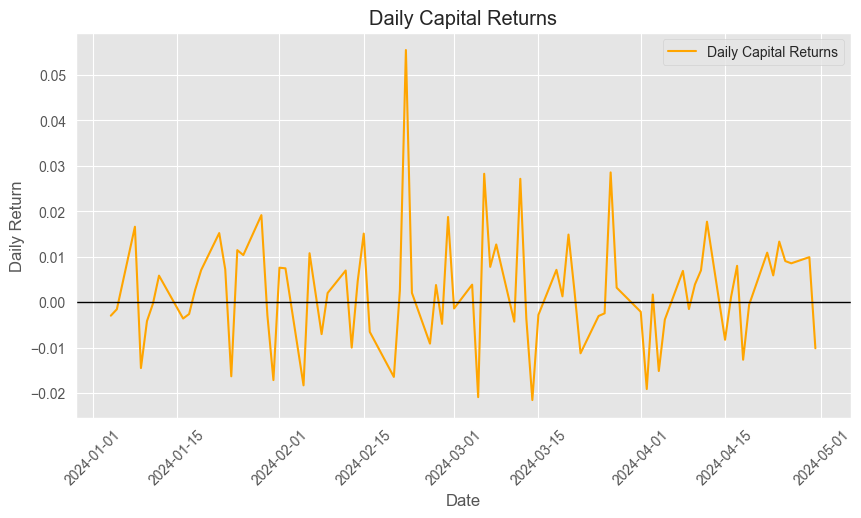

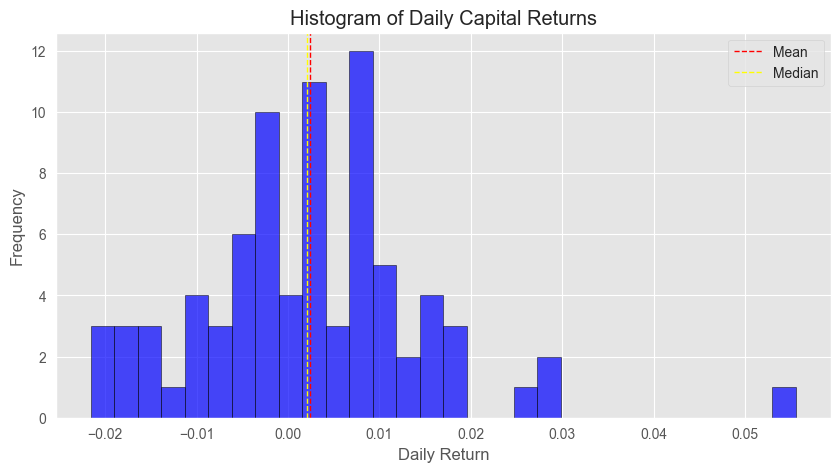

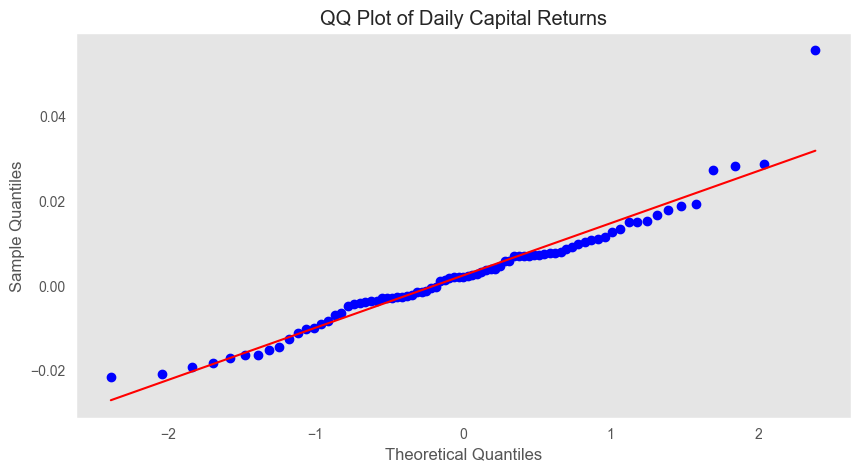

Shapiro-Wilk Test Statistic: 0.9459
Shapiro-Wilk Test p-value: 0.0019
Reject the null hypothesis: Daily returns are not normally distributed.


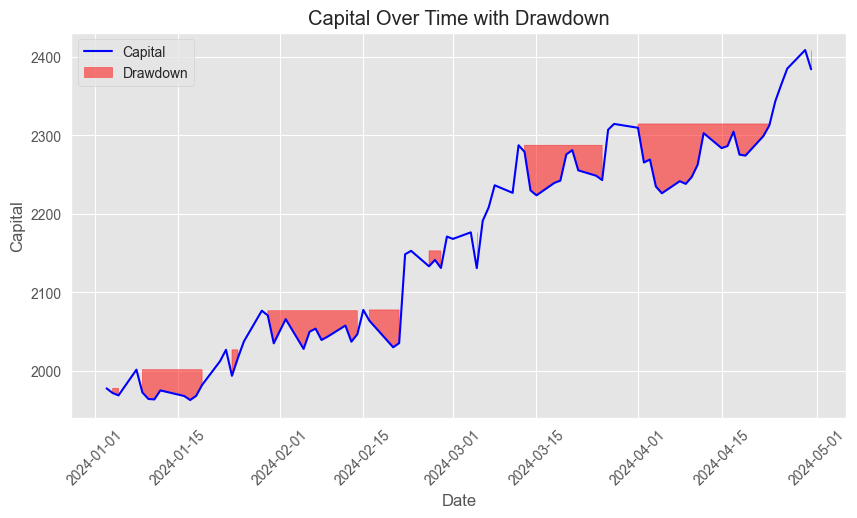

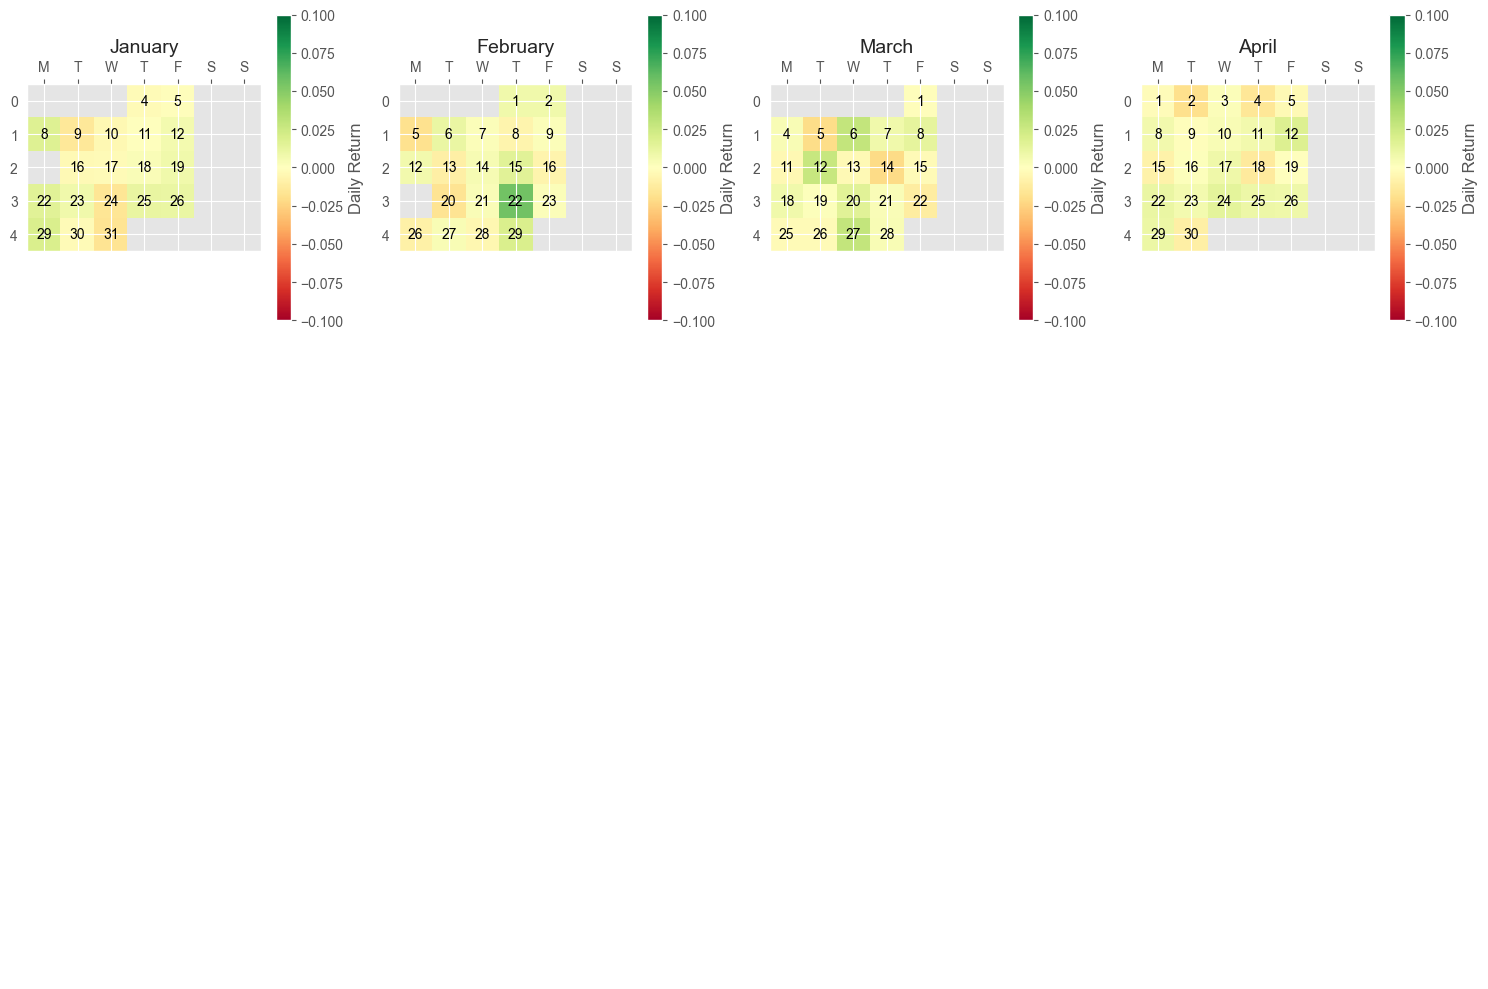

In [2]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Set plot style
style.use('ggplot')

sp500_df = pd.read_csv(r'D:\pycharm\pythonProject\sp500_companies_info.csv')

# Define the list of active U.S. stock tickers
active_tickers = sp500_df['Symbol'].tolist()
start_date = '2024-01-01'
end_date = '2024-05-01'

tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Get the data for these tickers from Yahoo Finance
data_full = yf.download(tickers.Symbol.to_list(), start_date, end_date, auto_adjust=True)['Close']
data_full = data_full.ffill()

if data_full.empty:
    raise ValueError("No valid data was fetched after filtering valid tickers.")

# Calculate daily returns
daily_returns = np.round(np.log(data_full / data_full.shift(1)).ffill(), 3)

# Identify biggest losers
biggest_losers = daily_returns.apply(lambda day: day.nsmallest(10).index, axis=1)

# Backtest capital allocation on biggest losers
capital = 2000
capital_over_time = pd.DataFrame(index=daily_returns.index)

for i in range(len(daily_returns.index) - 1):
    losers = biggest_losers.iloc[i]
    prices_today_close = data_full.loc[daily_returns.index[i], losers]
    prices_tomorrow_close = data_full.loc[daily_returns.index[i + 1], losers]
    shares = (capital / 10) / prices_today_close
    capital = (shares * prices_tomorrow_close).sum()
    capital_over_time.loc[daily_returns.index[i + 1], 'Capital'] = capital

initial_capital = 2000

# Calculate total return
total_return = capital_over_time['Capital'].iloc[-1] - initial_capital

# Calculate ROI
roi = total_return / initial_capital

# Calculate the number of days for annualization
days = (capital_over_time.index[-1] - capital_over_time.index[0]).days

# Calculate annualized return
annualized_return = ((capital_over_time['Capital'].iloc[-1] / initial_capital) ** (365 / days)) - 1


daily_capital_returns = capital_over_time['Capital'].pct_change().dropna()
volatility = daily_capital_returns.std() * np.sqrt(252)
rolling_max = capital_over_time['Capital'].cummax()
drawdown = (capital_over_time['Capital'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()
risk_free_rate = 0.01
sharpe_ratio = (daily_capital_returns.mean() - risk_free_rate) / daily_capital_returns.std()

num_trades = len(capital_over_time) - 1
winning_trades = daily_capital_returns[daily_capital_returns > 0].count()
losing_trades = daily_capital_returns[daily_capital_returns < 0].count()
win_rate = winning_trades / num_trades if num_trades > 0 else 0
average_profit = daily_capital_returns[daily_capital_returns > 0].mean()
average_loss = daily_capital_returns[daily_capital_returns < 0].mean()

# Additional Metrics
downside_returns = daily_capital_returns[daily_capital_returns < 0]
sortino_ratio = (daily_capital_returns.mean() - risk_free_rate) / downside_returns.std()
calmar_ratio = annualized_return / abs(max_drawdown)

# Print evaluation results
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Capital: ${capital_over_time['Capital'].iloc[-1]:.2f}")
print(f"Total Return: ${total_return:.2f} ({roi:.2%})")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Number of Trades: {num_trades}")
print(f"Winning Trades: {winning_trades} ({win_rate:.2%})")
print(f"Losing Trades: {losing_trades} ({(losing_trades / num_trades if num_trades > 0 else 0):.2%})")
print(f"Average Profit per Winning Trade: {average_profit:.2f}")
print(f"Average Loss per Losing Trade: {average_loss:.2f}")

# Visualize daily capital returns
plt.figure(figsize=(10, 5))
plt.plot(daily_capital_returns.index, daily_capital_returns, label='Daily Capital Returns', color='orange')
plt.axhline(0, color='black', lw=1)
plt.title('Daily Capital Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot the histogram of daily returns
plt.figure(figsize=(10, 5))
plt.hist(daily_capital_returns, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Daily Capital Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.axvline(daily_capital_returns.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(daily_capital_returns.median(), color='yellow', linestyle='dashed', linewidth=1)
plt.legend({'Mean': daily_capital_returns.mean(), 'Median': daily_capital_returns.median()})
plt.show()

# QQ Plot
plt.figure(figsize=(10, 5))
stats.probplot(daily_capital_returns, dist="norm", plot=plt)
plt.title('QQ Plot of Daily Capital Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid()
plt.show()

# Perform the Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(daily_capital_returns)

# Print the results of the normality test
alpha = 0.05  # significance level
print(f'Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}')
print(f'Shapiro-Wilk Test p-value: {shapiro_p:.4f}')

# Conclusion based on the p-value
if shapiro_p > alpha:
    print('Fail to reject the null hypothesis: Daily returns are normally distributed.')
else:
    print('Reject the null hypothesis: Daily returns are not normally distributed.')

# Visualize capital over time with drawdown
plt.figure(figsize=(10, 5))
plt.plot(capital_over_time.index, capital_over_time['Capital'], label='Capital', color='blue')
plt.fill_between(capital_over_time.index, capital_over_time['Capital'], rolling_max, where=(capital_over_time['Capital'] < rolling_max), color='red', alpha=0.5, label='Drawdown')
plt.title('Capital Over Time with Drawdown')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.xticks(rotation=45)
plt.legend()
plt.show()


def main(daily_returns):
    dates = daily_returns.index
    data = daily_returns.values
    
    # Create a figure with subplots for each month
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows and 4 columns for 12 months
    for ax, month in zip(axs.flatten(), range(1, 13)):
        # Filter dates and data for the current month
        month_dates = dates[dates.month == month]
        month_data = data[dates.month == month]

        # Only plot if there's data for the month
        if len(month_data) > 0:
            calendar_heatmap(ax, month_dates, month_data, month)
        else:
            ax.axis('off')  # Turn off the axis if no data for the month

    plt.tight_layout()
    plt.show()

def calendar_array(dates, data):
    if len(dates) == 0:  # Check if there are any dates
        return [], [], np.nan * np.zeros((6, 7))  # Return empty arrays and a blank calendar

    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar

def calendar_heatmap(ax, dates, data, month):
    i, j, calendar = calendar_array(dates, data)
    
    if len(i) > 0 and len(j) > 0:  # Ensure there are valid indices to plot
        im = ax.imshow(calendar, interpolation='none', cmap='RdYlGn', vmin=-0.1, vmax=0.1)
        label_days(ax, dates, i, j, calendar)
        ax.set_title(dt.date(2020, month, 1).strftime('%B'), fontsize=14)
        ax.figure.colorbar(im, ax=ax, label='Daily Return')

def label_days(ax, dates, i, j, calendar):
    day_of_month = np.nan * np.zeros(calendar.shape)
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center', color='black')

    ax.set(xticks=np.arange(7), 
           xticklabels=['M', 'T', 'W', 'T', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

# Assuming daily_capital_returns is already calculated as in your previous code
main(daily_capital_returns)

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-05-01)')
['SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-05-01) (Yahoo error = "Data doesn\'t exist for startDate = 1704085200, endDate = 1714536000")')


Initial Capital: $5000.00
Final Capital: $291.22
Total Return: $-4708.78 (-94.18%)
Annualized Return: -99.98%
Annualized Volatility: 78.05%
Maximum Drawdown: -94.31%
Sharpe Ratio: -0.88
Sortino Ratio: -0.88
Calmar Ratio: -1.06
Number of Trades: 82
Winning Trades: 27 (32.93%)
Losing Trades: 54 (65.85%)
Average Profit per Winning Trade: 0.01
Average Loss per Losing Trade: -0.05


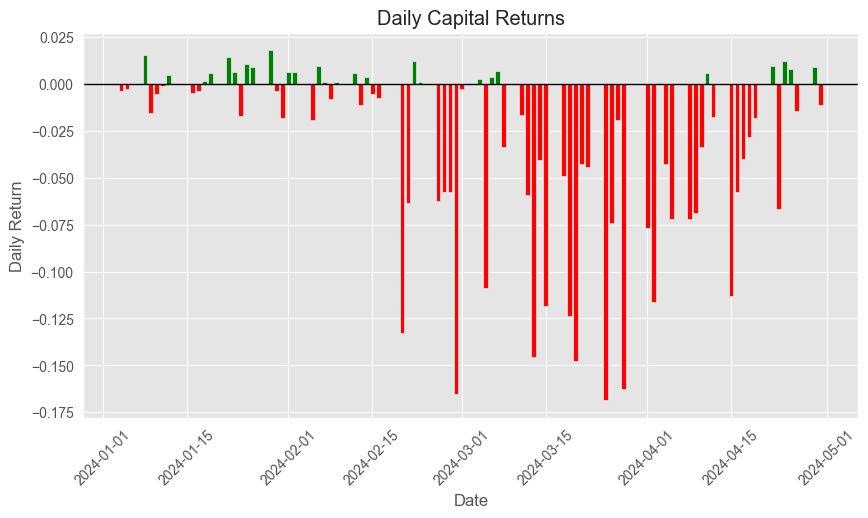

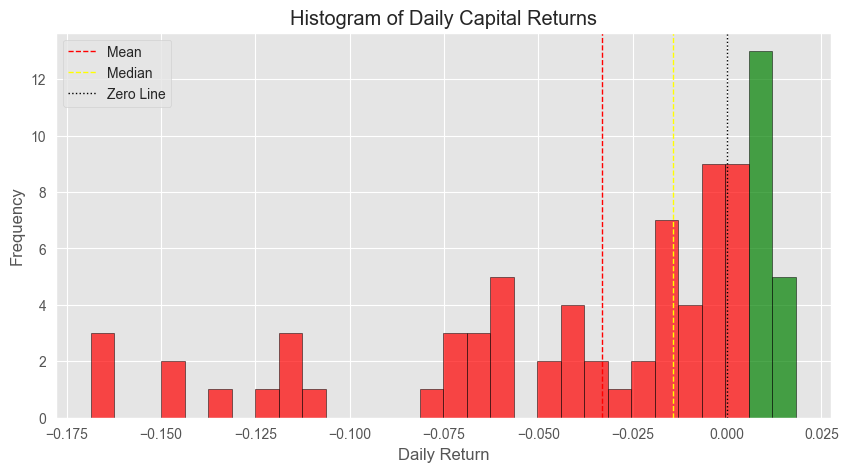

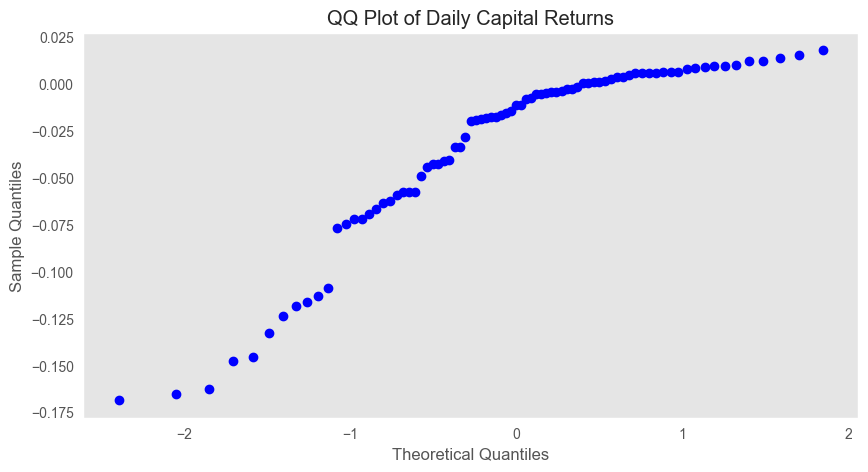

Shapiro-Wilk Test Statistic: nan
Shapiro-Wilk Test p-value: nan
Reject the null hypothesis: Daily returns are not normally distributed.


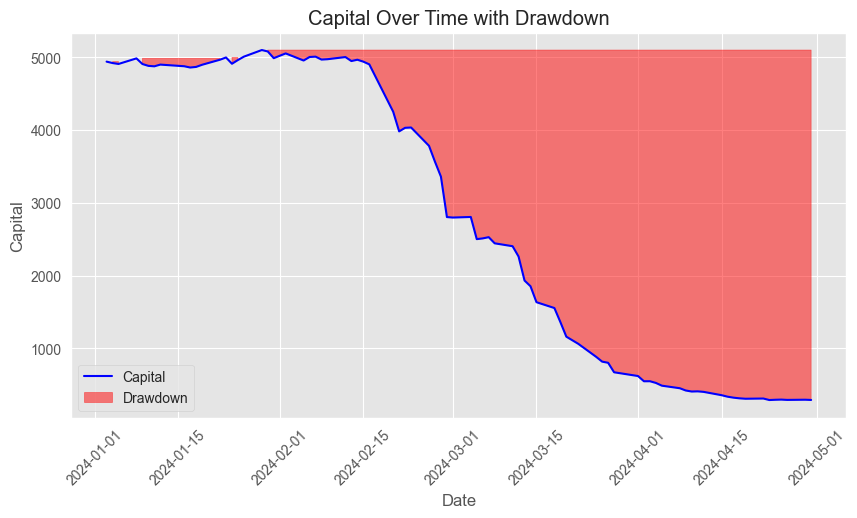

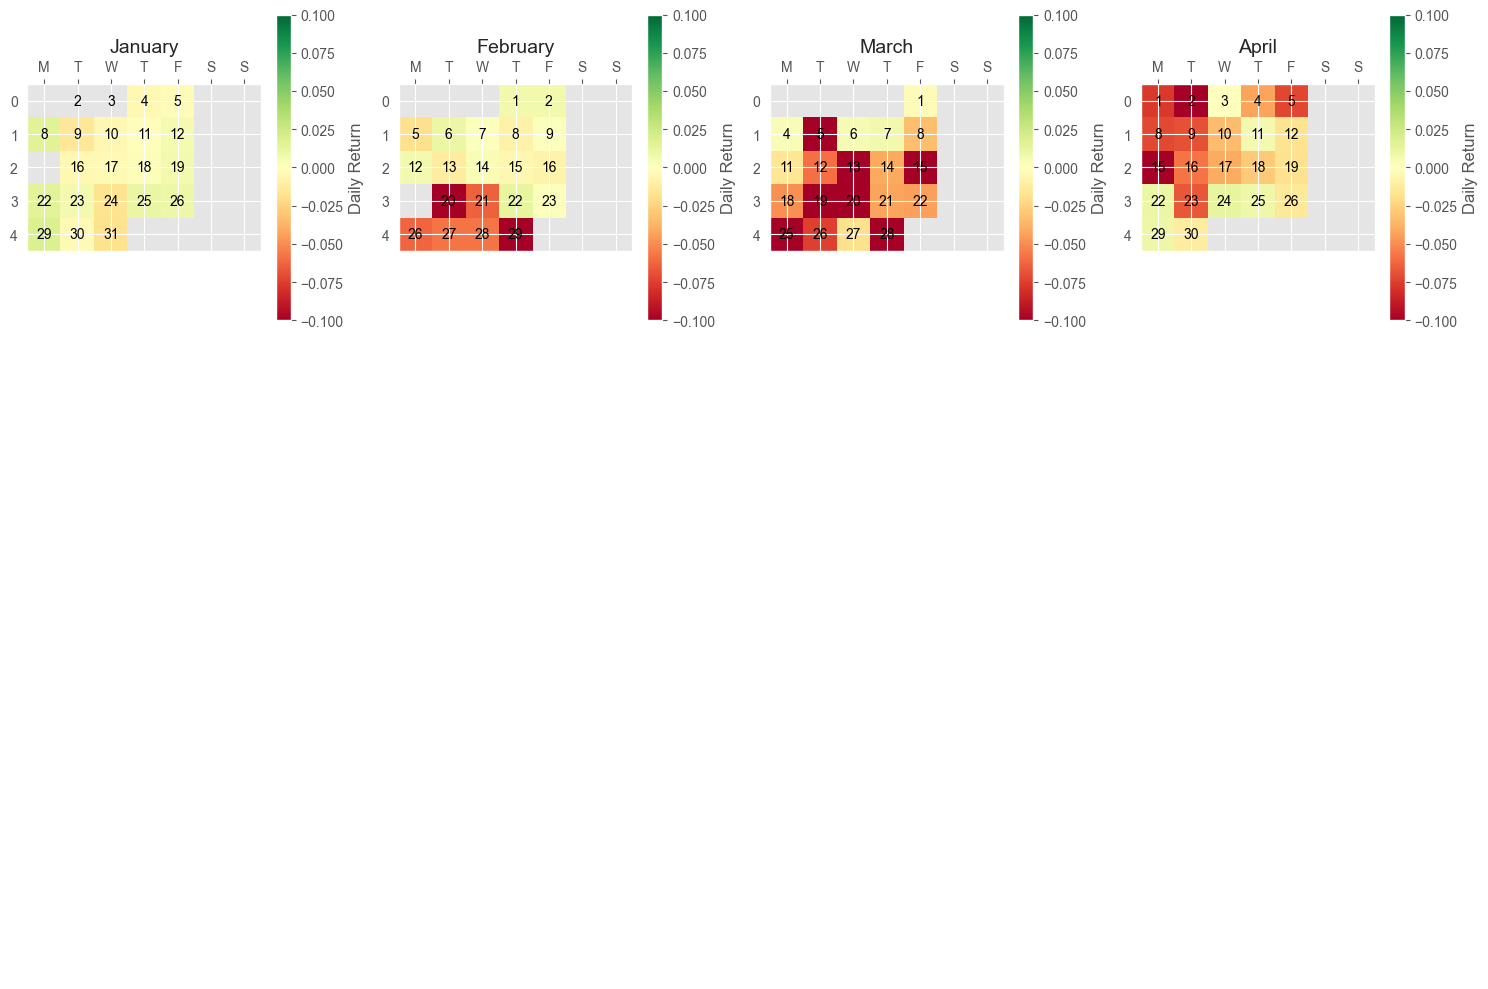

In [30]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from scipy import stats
import july
from july.utils import date_range
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

# Set plot style
style.use('ggplot')

# Load S&P 500 companies data
sp500_df = pd.read_csv(r'D:\pycharm\pythonProject\sp500_companies_info.csv')

# Define the list of active U.S. stock tickers
active_tickers = sp500_df['Symbol'].tolist()
start_date = '2024-01-01'
end_date = '2024-05-01'

tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]


# Get the data for this tickers from yahoo finance
data_full = yf.download(tickers.Symbol.to_list(), start_date, end_date, auto_adjust=True)[['Close', 'Volume']]

# Calculate daily returns
daily_returns = np.round(np.log(data_full['Close'] / data_full['Close'].shift(1)).ffill(), 3)

# Identify biggest losers
biggest_losers = daily_returns.apply(lambda day: day.nsmallest(10).index, axis=1)

# Backtest capital allocation on biggest losers
capital = 5000
capital_over_time = pd.DataFrame(index=daily_returns.index)

# Slippage and liquidity parameters
default_slippage_percentage = 0.001  # 0.1%
low_liquidity_slippage_percentage = 0.05  # 5% for low liquidity
min_volume_threshold = 1000000  # Minimum volume for full execution

for i in range(len(daily_returns.index) - 1):
    losers = biggest_losers.iloc[i]
    prices_today_close = data_full['Close'].loc[daily_returns.index[i], losers]
    prices_tomorrow_close = data_full['Close'].loc[daily_returns.index[i + 1], losers]
    volumes = data_full['Volume'].loc[daily_returns.index[i], losers]

    # Calculate average volume over the last 30 days
    avg_volume_30d = data_full['Volume'].rolling(window=30).mean().loc[daily_returns.index[i], losers]

    # Calculate shares considering slippage
    executed_shares = []
    remaining_shares = 0
    for j, ticker in enumerate(losers):
        # Determine slippage based on liquidity
        if volumes.iloc[j] < avg_volume_30d.iloc[j]:
            slippage = low_liquidity_slippage_percentage
            shares = (capital / 10) / (prices_today_close.iloc[j] * (1 + slippage))
            partial_shares = shares * (volumes.iloc[j] / avg_volume_30d.iloc[j])  # Partial execution
            executed_shares.append(partial_shares)
            remaining_shares += shares - partial_shares
        else:
            slippage = default_slippage_percentage
            shares = (capital / 10) / (prices_today_close.iloc[j] * (1 + slippage))
            executed_shares.append(shares)  # Full execution

    # Calculate new capital based on executed shares
    capital = (np.array(executed_shares) * prices_tomorrow_close).sum() + remaining_shares
    capital_over_time.loc[daily_returns.index[i + 1], 'Capital'] = capital

initial_capital = 5000

# Calculate total return
total_return = capital_over_time['Capital'].iloc[-1] - initial_capital

# Calculate ROI
roi = total_return / initial_capital

# Calculate the number of days for annualization
days = (capital_over_time.index[-1] - capital_over_time.index[0]).days

# Calculate annualized return
annualized_return = ((capital_over_time['Capital'].iloc[-1] / initial_capital) ** (365 / days)) - 1

daily_capital_returns = capital_over_time['Capital'].pct_change().ffill()
volatility = daily_capital_returns.std() * np.sqrt(252)
rolling_max = capital_over_time['Capital'].cummax()
drawdown = (capital_over_time['Capital'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()
risk_free_rate = 0.01
sharpe_ratio = (daily_capital_returns.mean() - risk_free_rate) / daily_capital_returns.std()

num_trades = len(capital_over_time) - 1
winning_trades = daily_capital_returns[daily_capital_returns > 0].count()
losing_trades = daily_capital_returns[daily_capital_returns < 0].count()
win_rate = winning_trades / num_trades if num_trades > 0 else 0
average_profit = daily_capital_returns[daily_capital_returns > 0].mean()
average_loss = daily_capital_returns[daily_capital_returns < 0].mean()

# Additional Metrics
downside_returns = daily_capital_returns[daily_capital_returns < 0]
sortino_ratio = (daily_capital_returns.mean() - risk_free_rate) / downside_returns.std()
calmar_ratio = annualized_return / abs(max_drawdown)

# Print evaluation results
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Capital: ${capital_over_time['Capital'].iloc[-1]:.2f}")
print(f"Total Return: ${total_return:.2f} ({roi:.2%})")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Number of Trades: {num_trades}")
print(f"Winning Trades: {winning_trades} ({win_rate:.2%})")
print(f"Losing Trades: {losing_trades} ({(losing_trades / num_trades if num_trades > 0 else 0):.2%})")
print(f"Average Profit per Winning Trade: {average_profit:.2f}")
print(f"Average Loss per Losing Trade: {average_loss:.2f}")


# Visualize daily capital returns
plt.figure(figsize=(10, 5))
colors = ['green' if value >= 0 else 'red' for value in daily_capital_returns]
plt.bar(daily_capital_returns.index, daily_capital_returns, color=colors)
plt.axhline(0, color='black', lw=1)
plt.title('Daily Capital Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)
plt.show()

# Histogram of daily returns
plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(daily_capital_returns, bins=30, alpha=0.7, edgecolor='black')
for patch in patches:
    if patch.get_x() <= 0:  # Negative values
        patch.set_facecolor('red')
    else:  # Positive values
        patch.set_facecolor('green')
plt.title('Histogram of Daily Capital Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.axvline(daily_capital_returns.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(daily_capital_returns.median(), color='yellow', linestyle='dashed', linewidth=1, label='Median')
plt.axvline(0, color='black', linestyle='dotted', linewidth=1, label='Zero Line')
plt.legend()
plt.show()

# QQ Plot
plt.figure(figsize=(10, 5))
stats.probplot(daily_capital_returns, dist="norm", plot=plt)
plt.title('QQ Plot of Daily Capital Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid()
plt.show()

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(daily_capital_returns)
alpha = 0.05
print(f'Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}')
print(f'Shapiro-Wilk Test p-value: {shapiro_p:.4f}')
if shapiro_p > alpha:
    print('Fail to reject the null hypothesis: Daily returns are normally distributed.')
else:
    print('Reject the null hypothesis: Daily returns are not normally distributed.')

# Visualize capital over time with drawdown
rolling_max = capital_over_time['Capital'].cummax()
plt.figure(figsize=(10, 5))
plt.plot(capital_over_time.index, capital_over_time['Capital'], label='Capital', color='blue')
plt.fill_between(capital_over_time.index, capital_over_time['Capital'], rolling_max, where=(capital_over_time['Capital'] < rolling_max), color='red', alpha=0.5, label='Drawdown')
plt.title('Capital Over Time with Drawdown')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.xticks(rotation=45)
plt.legend()
plt.show()

def main(daily_returns):
    dates = daily_returns.index
    data = daily_returns.values
    
    # Create a figure with subplots for each month
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows and 4 columns for 12 months
    for ax, month in zip(axs.flatten(), range(1, 13)):
        # Filter dates and data for the current month
        month_dates = dates[dates.month == month]
        month_data = data[dates.month == month]

        # Only plot if there's data for the month
        if len(month_data) > 0:
            calendar_heatmap(ax, month_dates, month_data, month)
        else:
            ax.axis('off')  # Turn off the axis if no data for the month

    plt.tight_layout()
    plt.show()

def calendar_array(dates, data):
    if len(dates) == 0:  # Check if there are any dates
        return [], [], np.nan * np.zeros((6, 7))  # Return empty arrays and a blank calendar

    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar

def calendar_heatmap(ax, dates, data, month):
    i, j, calendar = calendar_array(dates, data)
    
    if len(i) > 0 and len(j) > 0:  # Ensure there are valid indices to plot
        im = ax.imshow(calendar, interpolation='none', cmap='RdYlGn', vmin=-0.1, vmax=0.1)
        label_days(ax, dates, i, j, calendar)
        ax.set_title(dt.date(2020, month, 1).strftime('%B'), fontsize=14)
        ax.figure.colorbar(im, ax=ax, label='Daily Return')

def label_days(ax, dates, i, j, calendar):
    day_of_month = np.nan * np.zeros(calendar.shape)
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center', color='black')

    ax.set(xticks=np.arange(7), 
           xticklabels=['M', 'T', 'W', 'T', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

# Assuming daily_capital_returns is already calculated as in your previous code
main(daily_capital_returns)


[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['TSCO', 'BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-07-01)')
['SW']: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


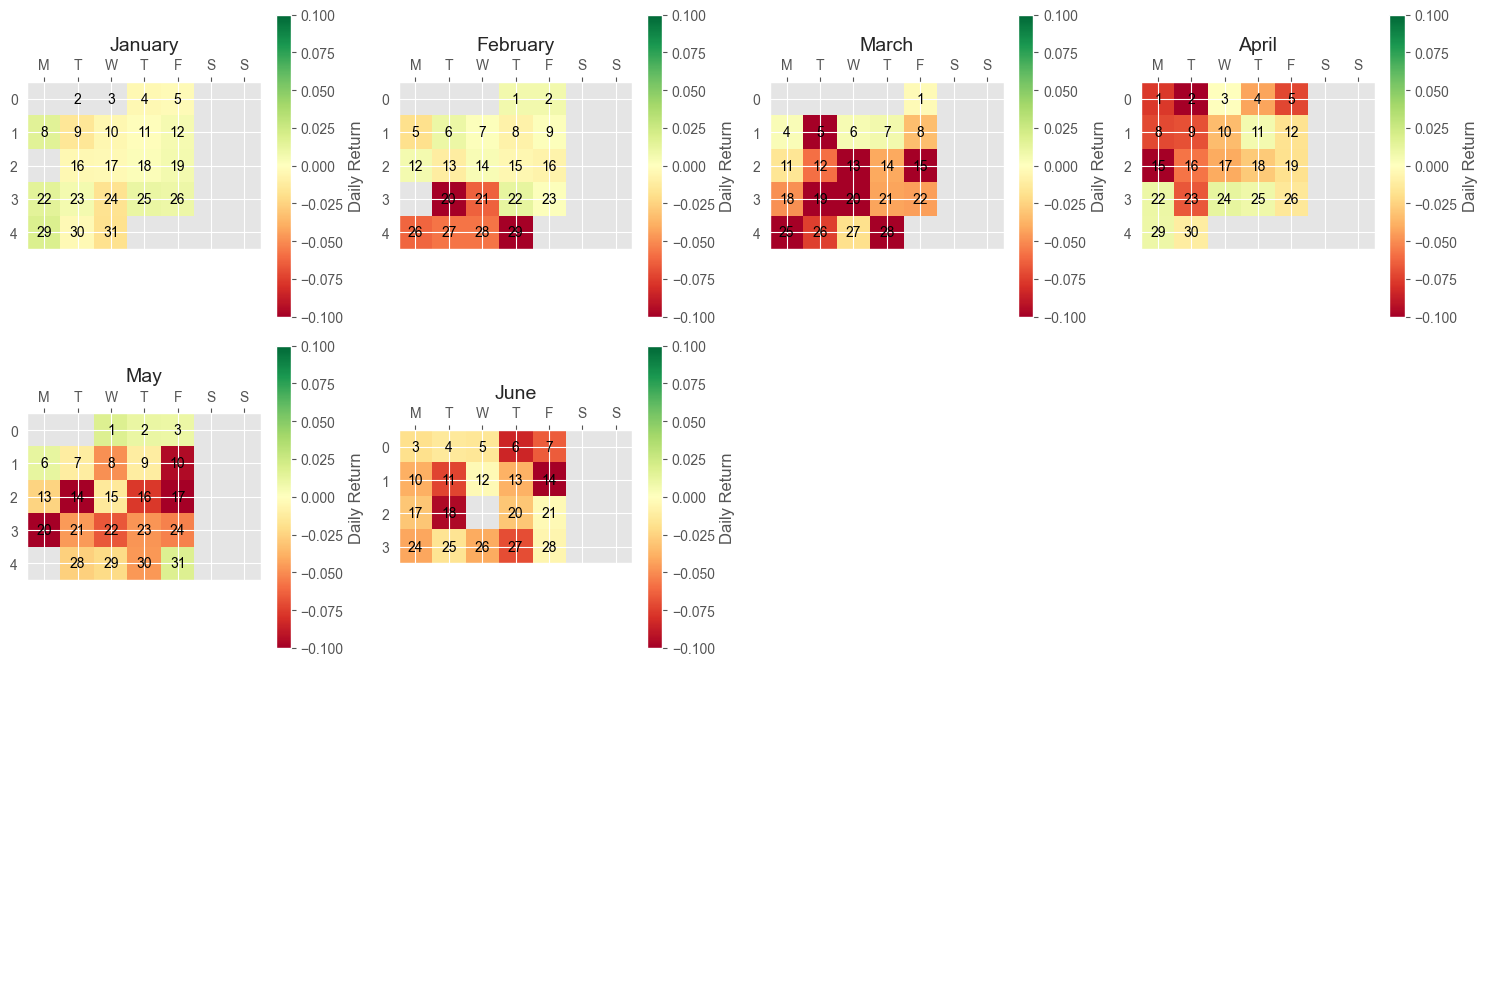

In [25]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats

# Load S&P 500 companies data
sp500_df = pd.read_csv(r'D:\pycharm\pythonProject\sp500_companies_info.csv')

# Define the list of active U.S. stock tickers
active_tickers = sp500_df['Symbol'].tolist()
start_date = '2024-01-01'
end_date = '2024-07-01'

tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Get the data for these tickers from Yahoo Finance
data_full = yf.download(tickers.Symbol.to_list(), start_date, end_date, auto_adjust=True)[['Close', 'Volume']]

# Calculate daily returns
daily_returns = np.round(np.log(data_full['Close'] / data_full['Close'].shift(1)).ffill(), 3)

# Identify biggest losers
biggest_losers = daily_returns.apply(lambda day: day.nsmallest(10).index, axis=1)

# Backtest capital allocation on biggest losers
capital = 5000
capital_over_time = pd.DataFrame(index=daily_returns.index)

# Slippage and liquidity parameters
default_slippage_percentage = 0.001  # 0.1%
low_liquidity_slippage_percentage = 0.05  # 5% for low liquidity
min_volume_threshold = 1000000  # Minimum volume for full execution

for i in range(len(daily_returns.index) - 1):
    losers = biggest_losers.iloc[i]
    prices_today_close = data_full['Close'].loc[daily_returns.index[i], losers]
    prices_tomorrow_close = data_full['Close'].loc[daily_returns.index[i + 1], losers]
    volumes = data_full['Volume'].loc[daily_returns.index[i], losers]

    # Calculate average volume over the last 30 days
    avg_volume_30d = data_full['Volume'].rolling(window=30).mean().loc[daily_returns.index[i], losers]

    # Calculate shares considering slippage
    executed_shares = []
    remaining_shares = 0
    for j, ticker in enumerate(losers):
        if volumes.iloc[j] < avg_volume_30d.iloc[j]:
            slippage = low_liquidity_slippage_percentage
            shares = (capital / 10) / (prices_today_close.iloc[j] * (1 + slippage))
            partial_shares = shares * (volumes.iloc[j] / avg_volume_30d.iloc[j])  # Partial execution
            executed_shares.append(partial_shares)
            remaining_shares += shares - partial_shares
        else:
            slippage = default_slippage_percentage
            shares = (capital / 10) / (prices_today_close.iloc[j] * (1 + slippage))
            executed_shares.append(shares)  # Full execution

    capital = (np.array(executed_shares) * prices_tomorrow_close).sum() + remaining_shares
    capital_over_time.loc[daily_returns.index[i + 1], 'Capital'] = capital

# Calculate total return
initial_capital = 5000
total_return = capital_over_time['Capital'].iloc[-1] - initial_capital

# Calculate ROI
roi = total_return / initial_capital

# Calculate daily capital returns
daily_capital_returns = capital_over_time['Capital'].pct_change().ffill()

# Visualize daily capital returns with Plotly
fig_returns = go.Figure()
fig_returns.add_trace(go.Scatter(x=daily_capital_returns.index, y=daily_capital_returns, mode='lines', name='Daily Capital Returns', line=dict(color='orange')))
fig_returns.add_hline(y=0, line_color='white')
fig_returns.update_layout(title='Daily Capital Returns', xaxis_title='Date', yaxis_title='Daily Return', xaxis_tickangle=-45)
fig_returns.show()

# Plotting Daily Capital Returns
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=daily_capital_returns.index, 
                      y=daily_capital_returns, 
                      marker_color=['green' if value >= 0 else 'red' for value in daily_capital_returns],
                      name='Daily Returns'))
fig1.add_hline(y=0, line_color='black')
fig1.update_layout(title='Daily Capital Returns',
                   xaxis_title='Date',
                   yaxis_title='Daily Return',
                   xaxis_tickangle=-45)
fig1.show()

# Create a DataFrame for the histogram
hist_data = pd.DataFrame({'Daily Returns': daily_capital_returns})

# Define a new column for color based on the daily returns
hist_data['Color'] = np.where(hist_data['Daily Returns'] < 0, 'red', 'green')

# Histogram of Daily Returns
fig2 = px.histogram(hist_data, 
                    x='Daily Returns', 
                    color='Color', 
                    title='Histogram of Daily Capital Returns',
                    color_discrete_map={'red': 'red', 'green': 'green'},
                    labels={'Daily Returns': 'Daily Return'},
                    nbins=30)

fig2.update_traces(marker=dict(line=dict(color='black', width=1)))  # Add edge color to bars
fig2.add_vline(x=daily_capital_returns.mean(), line_dash='dash', line_color='red', 
               annotation_text='Mean', annotation_position='top right')
fig2.add_vline(x=daily_capital_returns.median(), line_dash='dash', line_color='yellow', 
               annotation_text='Median', annotation_position='top right')
fig2.show()

# QQ Plot using Plotly
quantiles = np.percentile(daily_capital_returns.dropna(), np.linspace(0, 100, len(daily_capital_returns.dropna())))
theoretical_quantiles = stats.norm.ppf(np.linspace(0, 1, len(quantiles)))

# Create the QQ plot
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=theoretical_quantiles, y=quantiles, mode='markers', name='Data Points'))
fig3.add_trace(go.Scatter(x=theoretical_quantiles, 
                           y=theoretical_quantiles, 
                           mode='lines', 
                           name='45-degree Line', 
                           line=dict(color='red', dash='dash')))
fig3.update_layout(title='QQ Plot of Daily Capital Returns',
                   xaxis_title='Theoretical Quantiles',
                   yaxis_title='Sample Quantiles',
                   yaxis=dict(range=[-0.2, 0.2]),  # Set the y-axis range
                   showlegend=True)
fig3.show()

# Visualize capital over time with drawdown
rolling_max = capital_over_time['Capital'].cummax()
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=capital_over_time.index, y=capital_over_time['Capital'], 
                           mode='lines', name='Capital', line=dict(color='blue')))
fig4.add_trace(go.Scatter(x=capital_over_time.index, 
                           y=rolling_max, mode='lines', name='Rolling Max', line=dict(color='orange', dash='dash')))
fig4.add_trace(go.Scatter(x=capital_over_time.index, 
                           y=capital_over_time['Capital'], 
                           fill='tonexty', fillcolor='rgba(255, 0, 0, 0.5)', 
                           name='Drawdown', line=dict(color='red', width=0)))
fig4.update_layout(title='Capital Over Time with Drawdown',
                   xaxis_title='Date',
                   yaxis_title='Capital',
                   xaxis_tickangle=-45)
fig4.show()

def main(daily_returns):
    dates = daily_returns.index
    data = daily_returns.values
    
    # Create a figure with subplots for each month
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows and 4 columns for 12 months
    for ax, month in zip(axs.flatten(), range(1, 13)):
        # Filter dates and data for the current month
        month_dates = dates[dates.month == month]
        month_data = data[dates.month == month]

        # Only plot if there's data for the month
        if len(month_data) > 0:
            calendar_heatmap(ax, month_dates, month_data, month)
        else:
            ax.axis('off')  # Turn off the axis if no data for the month

    plt.tight_layout()
    plt.show()

def calendar_array(dates, data):
    if len(dates) == 0:  # Check if there are any dates
        return [], [], np.nan * np.zeros((6, 7))  # Return empty arrays and a blank calendar

    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar

def calendar_heatmap(ax, dates, data, month):
    i, j, calendar = calendar_array(dates, data)
    
    if len(i) > 0 and len(j) > 0:  # Ensure there are valid indices to plot
        im = ax.imshow(calendar, interpolation='none', cmap='RdYlGn', vmin=-0.1, vmax=0.1)
        label_days(ax, dates, i, j, calendar)
        ax.set_title(dt.date(2020, month, 1).strftime('%B'), fontsize=14)
        ax.figure.colorbar(im, ax=ax, label='Daily Return')

def label_days(ax, dates, i, j, calendar):
    day_of_month = np.nan * np.zeros(calendar.shape)
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center', color='black')

    ax.set(xticks=np.arange(7), 
           xticklabels=['M', 'T', 'W', 'T', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

# Assuming daily_capital_returns is already calculated as in your previous code
main(daily_capital_returns)

[*********************100%***********************]  503 of 503 completed

204 Failed downloads:
['SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2024-01-01 -> 2024-07-01) (Yahoo error = "Data doesn\'t exist for startDate = 1704085200, endDate = 1719806400")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['DELL', 'EVRG', 'BLDR', 'CMCSA', 'AIG', 'ROP', 'RJF', 'CEG', 'AWK', 'KDP', 'FSLR', 'KMI', 'WEC', 'LIN', 'DOV', 'NOW', 'AVY', 'MCK', 'FTV', 'MOH', 'CSGP', 'PG', 'FANG', 'WBD', 'YUM', 'HSY', 'OTIS', 'BXP', 'DLTR', 'HII', 'ETN', 'CPB', 'HRL', 'WYNN', 'FAST', 'SYK', 'SYY', 'PSX', 'GOOGL', 'BF.B', 'VRSK', 'AME', 'XOM', 'JNPR', 'STE', 'ZBRA', 'DFS', 'PFG', 'COST', 'HLT', 'FTNT', 'NUE', 'CCL', 'LUV', 'TPR', 'TMO', 'MDLZ', 'BK', 'TMUS', 'HES', 'APH', 'GM', 'EBAY', 'IBM', 'EA', 'OXY', 'DXCM', 'CDW', 'NVDA', 'KEYS', 'MPWR', 'DG', 'WST', 'AKAM', 'JNJ', 'ULTA', 'NWS', 'APTV', 'ORLY', 'UPS', 'PGR', 'MDT', 'ANET', 'BKNG', 'DTE', '

Initial Capital: $5000.00
Final Capital: $3039.14
Total Return: $-1960.86 (-39.22%)
Annualized Return: -63.97%
Annualized Volatility: 17.54%
Maximum Drawdown: -4.68%
Sharpe Ratio: -0.75
Sortino Ratio: -1.02
Calmar Ratio: -13.67
Number of Trades: 123
Winning Trades: 73 (59.35%)
Losing Trades: 49 (39.84%)
Average Profit per Winning Trade: 0.01
Average Loss per Losing Trade: -0.01


Shapiro-Wilk Test Statistic: 0.9732
Shapiro-Wilk Test p-value: 0.0155
Reject the null hypothesis: Daily returns are not normally distributed.


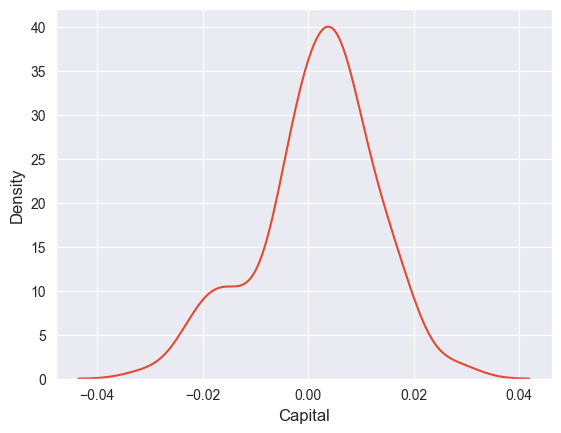

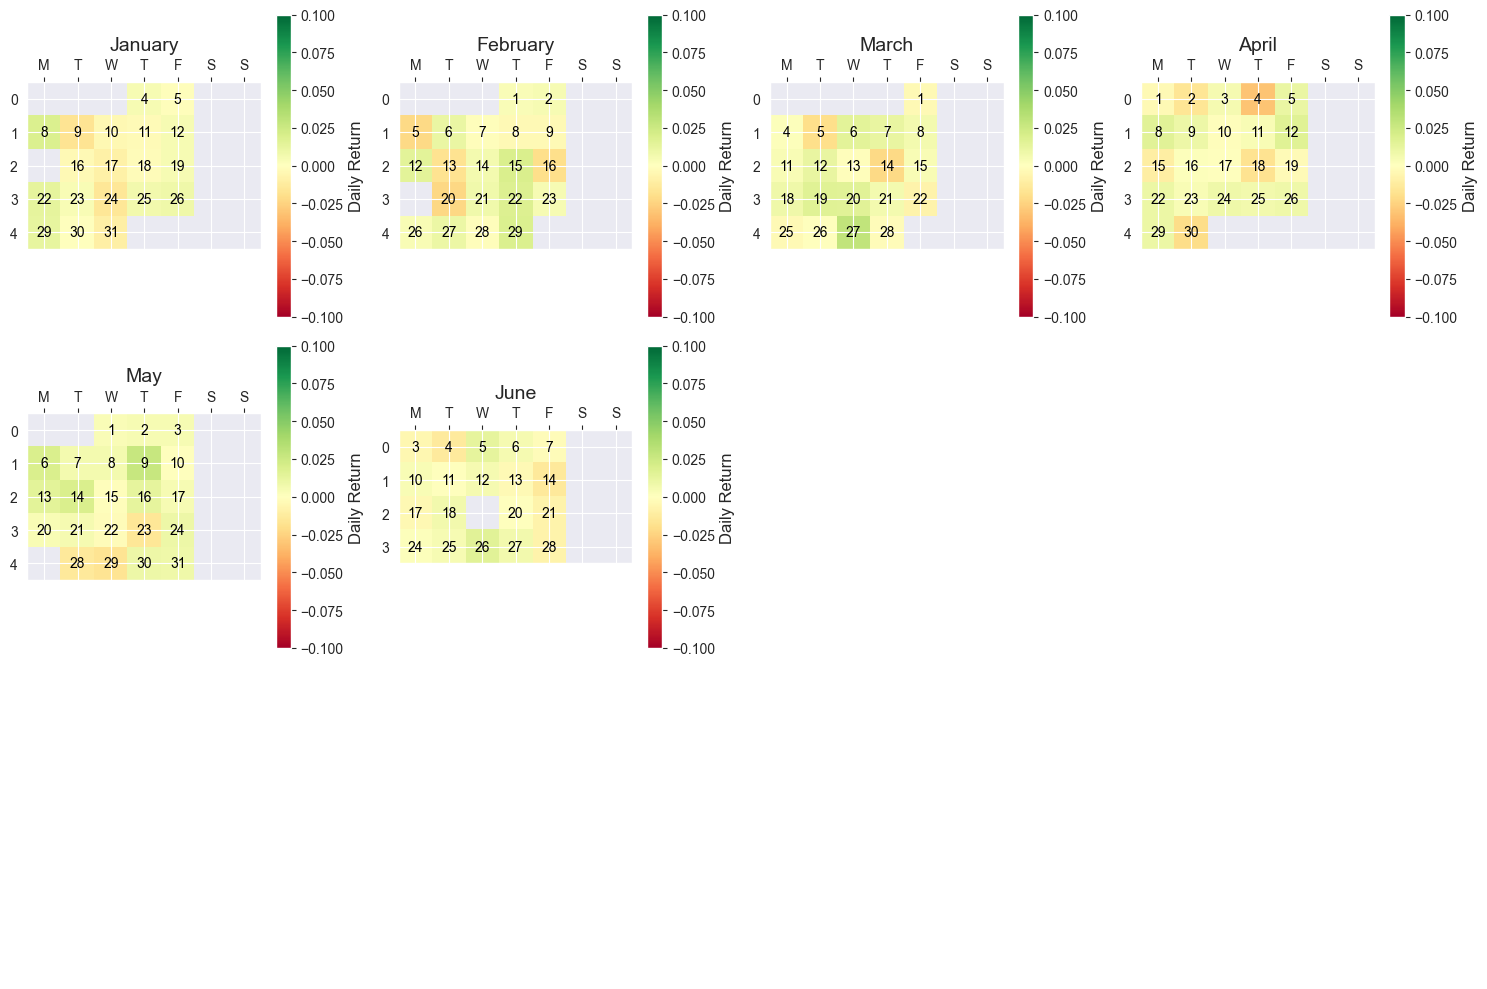

In [33]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import statsmodels.api as sm
from scipy import stats
from plotly.subplots import make_subplots
import seaborn as sns

# Load S&P 500 data
sp500_df = pd.read_csv(r'D:\pycharm\pythonProject\sp500_companies_info.csv')

# Define the list of active U.S. stock tickers
active_tickers = sp500_df['Symbol'].tolist()
start_date = '2024-01-01'
end_date = '2024-07-01'

tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Get the data for these tickers from Yahoo Finance
data_full = yf.download(tickers.Symbol.to_list(), start_date, end_date, auto_adjust=True)['Close']
data_full = data_full.ffill()

if data_full.empty:
    raise ValueError("No valid data was fetched after filtering valid tickers.")

# Calculate daily returns
daily_returns = np.round(np.log(data_full / data_full.shift(1)).ffill(), 3)

# Identify biggest losers
biggest_losers = daily_returns.apply(lambda day: day.nsmallest(10).index, axis=1)

# Backtest capital allocation on biggest losers
capital = 5000
capital_over_time = pd.DataFrame(index=daily_returns.index)

for i in range(len(daily_returns.index) - 1):
    losers = biggest_losers.iloc[i]
    prices_today_close = data_full.loc[daily_returns.index[i], losers]
    prices_tomorrow_close = data_full.loc[daily_returns.index[i + 1], losers]
    shares = (capital / 10) / prices_today_close
    capital = (shares * prices_tomorrow_close).sum()
    capital_over_time.loc[daily_returns.index[i + 1], 'Capital'] = capital

initial_capital = 5000

# Calculate total return
total_return = capital_over_time['Capital'].iloc[-1] - initial_capital

# Calculate ROI
roi = total_return / initial_capital

# Calculate the number of days for annualization
days = (capital_over_time.index[-1] - capital_over_time.index[0]).days

# Calculate annualized return
annualized_return = ((capital_over_time['Capital'].iloc[-1] / initial_capital) ** (365 / days)) - 1

daily_capital_returns = capital_over_time['Capital'].pct_change().dropna()
volatility = daily_capital_returns.std() * np.sqrt(252)
rolling_max = capital_over_time['Capital'].cummax()
drawdown = (capital_over_time['Capital'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()
risk_free_rate = 0.01
sharpe_ratio = (daily_capital_returns.mean() - risk_free_rate) / daily_capital_returns.std()

num_trades = len(capital_over_time) - 1
winning_trades = daily_capital_returns[daily_capital_returns > 0].count()
losing_trades = daily_capital_returns[daily_capital_returns < 0].count()
win_rate = winning_trades / num_trades if num_trades > 0 else 0
average_profit = daily_capital_returns[daily_capital_returns > 0].mean()
average_loss = daily_capital_returns[daily_capital_returns < 0].mean()

# Additional Metrics
downside_returns = daily_capital_returns[daily_capital_returns < 0]
sortino_ratio = (daily_capital_returns.mean() - risk_free_rate) / downside_returns.std()
calmar_ratio = annualized_return / abs(max_drawdown)

# Print evaluation results
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Capital: ${capital_over_time['Capital'].iloc[-1]:.2f}")
print(f"Total Return: ${total_return:.2f} ({roi:.2%})")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Number of Trades: {num_trades}")
print(f"Winning Trades: {winning_trades} ({win_rate:.2%})")
print(f"Losing Trades: {losing_trades} ({(losing_trades / num_trades if num_trades > 0 else 0):.2%})")
print(f"Average Profit per Winning Trade: {average_profit:.2f}")
print(f"Average Loss per Losing Trade: {average_loss:.2f}")

# Visualize daily capital returns with Plotly
fig_returns = go.Figure()
fig_returns.add_trace(go.Scatter(x=daily_capital_returns.index, y=daily_capital_returns, mode='lines', name='Daily Capital Returns', line=dict(color='orange')))
fig_returns.add_hline(y=0, line_color='black')
fig_returns.update_layout(title='Daily Capital Returns', xaxis_title='Date', yaxis_title='Daily Return', xaxis_tickangle=-45)
fig_returns.show()

# Plotting Daily Capital Returns
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=daily_capital_returns.index, 
                      y=daily_capital_returns, 
                      marker_color=['green' if value >= 0 else 'red' for value in daily_capital_returns],
                      name='Daily Returns'))
fig1.add_hline(y=0, line_color='black')
fig1.update_layout(title='Daily Capital Returns',
                   xaxis_title='Date',
                   yaxis_title='Daily Return',
                   xaxis_tickangle=-45)
fig1.show()

# Create a DataFrame for the histogram
hist_data = pd.DataFrame({'Daily Returns': daily_capital_returns})

n, bins = np.histogram(daily_capital_returns, bins=30, density=True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Calculate kernel density estimate
kde = sns.kdeplot(daily_capital_returns, bw_adjust=1, common_norm=False, fill=False).get_lines()[0]
kde_x = kde.get_xdata()
kde_y = kde.get_ydata()

# Create the histogram trace
hist_trace = go.Bar(
    x=bin_centers,
    y=n,
    width=np.diff(bins),
    marker=dict(
        color=['red' if bc <= 0 else 'green' for bc in bin_centers],
        line=dict(color='black', width=1)
    ),
    opacity=0.7,
    name='Histogram'
)

# Create the KDE trace
kde_trace = go.Scatter(
    x=kde_x,
    y=kde_y,
    mode='lines',
    name='Kernel Density Estimate',
    line=dict(color='blue', width=2)
)

# Create mean and median lines
mean_line = go.Scatter(
    x=[np.mean(daily_capital_returns)] * 2,
    y=[0, max(n)],
    mode='lines',
    name='Mean',
    line=dict(color='red', dash='dash')
)

median_line = go.Scatter(
    x=[np.median(daily_capital_returns)] * 2,
    y=[0, max(n)],
    mode='lines',
    name='Median',
    line=dict(color='yellow', dash='dash')
)

zero_line = go.Scatter(
    x=[0, 0],
    y=[0, max(n)],
    mode='lines',
    name='Zero Line',
    line=dict(color='black', dash='dot')
)

# Create the figure
fig = go.Figure(data=[hist_trace, kde_trace, mean_line, median_line, zero_line])

# Update layout
fig.update_layout(
    title='Histogram of Daily Capital Returns with Kernel Density Estimate',
    xaxis_title='Daily Return',
    yaxis_title='Density',
    barmode='overlay'
)

# Show the figure
fig.show()

# QQ Plot using Plotly
df = len(daily_capital_returns) - 1
quantiles = np.percentile(daily_capital_returns.dropna(), np.linspace(0, 100, len(daily_capital_returns.dropna())))
theoretical_quantiles = stats.t.ppf(np.linspace(0, 1, len(quantiles)), df)

# Create the QQ plot
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=theoretical_quantiles, y=quantiles, mode='markers', name='Data Points'))
fig3.add_trace(go.Scatter(x=theoretical_quantiles, 
                           y=theoretical_quantiles, 
                           mode='lines', 
                           name='45-degree Line', 
                           line=dict(color='red', dash='dash')))
fig3.update_layout(title='QQ Plot of Daily Capital Returns',
                   xaxis_title='Theoretical Quantiles',
                   yaxis_title='Sample Quantiles',
                   yaxis=dict(range=[-0.05, 0.05]),  # Set the y-axis range
                   showlegend=True)
fig3.show()

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(daily_capital_returns)
alpha = 0.05
print(f'Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}')
print(f'Shapiro-Wilk Test p-value: {shapiro_p:.4f}')
if shapiro_p > alpha:
    print('Fail to reject the null hypothesis: Daily returns are normally distributed.')
else:
    print('Reject the null hypothesis: Daily returns are not normally distributed.')

# Visualize capital over time with drawdown
rolling_max = capital_over_time['Capital'].cummax()
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=capital_over_time.index, y=capital_over_time['Capital'], 
                           mode='lines', name='Capital', line=dict(color='blue')))
fig4.add_trace(go.Scatter(x=capital_over_time.index, 
                           y=rolling_max, mode='lines', name='Rolling Max', line=dict(color='orange', dash='dash')))
fig4.add_trace(go.Scatter(x=capital_over_time.index, 
                           y=capital_over_time['Capital'], 
                           fill='tonexty', fillcolor='rgba(255, 0, 0, 0.5)', 
                           name='Drawdown', line=dict(color='red', width=0)))
fig4.update_layout(title='Capital Over Time with Drawdown',
                   xaxis_title='Date',
                   yaxis_title='Capital',
                   xaxis_tickangle=-45)
fig4.show()



def main(daily_returns):
    dates = daily_returns.index
    data = daily_returns.values
    
    # Create a figure with subplots for each month
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows and 4 columns for 12 months
    for ax, month in zip(axs.flatten(), range(1, 13)):
        # Filter dates and data for the current month
        month_dates = dates[dates.month == month]
        month_data = data[dates.month == month]

        # Only plot if there's data for the month
        if len(month_data) > 0:
            calendar_heatmap(ax, month_dates, month_data, month)
        else:
            ax.axis('off')  # Turn off the axis if no data for the month

    plt.tight_layout()
    plt.show()

def calendar_array(dates, data):
    if len(dates) == 0:  # Check if there are any dates
        return [], [], np.nan * np.zeros((6, 7))  # Return empty arrays and a blank calendar

    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar

def calendar_heatmap(ax, dates, data, month):
    i, j, calendar = calendar_array(dates, data)
    
    if len(i) > 0 and len(j) > 0:  # Ensure there are valid indices to plot
        im = ax.imshow(calendar, interpolation='none', cmap='RdYlGn', vmin=-0.1, vmax=0.1)
        label_days(ax, dates, i, j, calendar)
        ax.set_title(dt.date(2020, month, 1).strftime('%B'), fontsize=14)
        ax.figure.colorbar(im, ax=ax, label='Daily Return')

def label_days(ax, dates, i, j, calendar):
    day_of_month = np.nan * np.zeros(calendar.shape)
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center', color='black')

    ax.set(xticks=np.arange(7), 
           xticklabels=['M', 'T', 'W', 'T', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

# Assuming daily_capital_returns is already calculated as in your previous code
main(daily_capital_returns)